# VariationalAutoEncoder 구현 및 manifold 결과 개선하기

입력 : 이미지 A
출력 : 이미지 A

In [9]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

from torchvision.utils import save_image
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from sklearn.manifold import TSNE
import pandas as pd

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [2]:
epochs = 50
batch_size = 256
learning_rate = 0.01
hidden_size = 10

In [3]:
# torchvision.datasets.FGVCAircraft
dataset = datasets.FashionMNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = datasets.FashionMNIST(root = './data/', train = False, download = True, transform = transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = 5, shuffle = True, num_workers = 2)

In [4]:
labels_num = dataset.targets.numpy()
labels = [class_names[i] for i in labels_num]

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, hidden_size)
        self.fc22 = nn.Linear(500, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
model = torch.load('VAE.pth').to(device)
model.eval()

VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc21): Linear(in_features=500, out_features=10, bias=True)
  (fc22): Linear(in_features=500, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=784, bias=True)
)

In [7]:
sample_image = dataset.data[:5].view(-1, 28*28)
sample_image = sample_image.type(torch.FloatTensor)/255.
sample_label = dataset.targets[:5]

with torch.no_grad():
    model.eval()
    test_image = sample_image.to(device)
    output, mu, logvar = model(test_image)

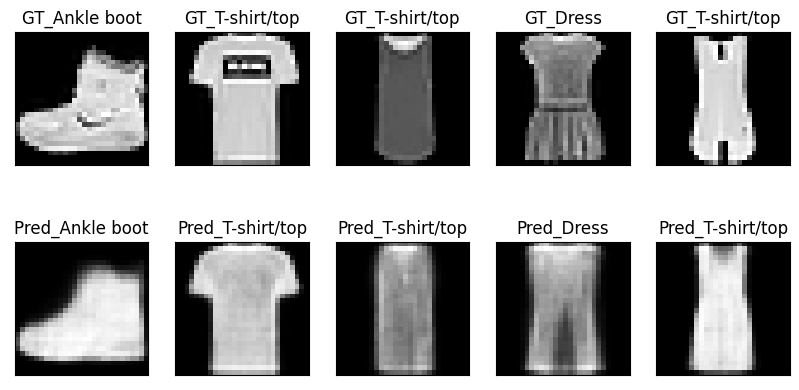

In [8]:
f, a = plt.subplots(2, 5, figsize=(10, 5))


for i in range(5):
    img = np.reshape(sample_image.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    a[0][i].set_title('GT_'+class_names[sample_label[i]])

for i in range(5):
    img = np.reshape(output.to("cpu").data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
    a[1][i].set_title('Pred_'+class_names[sample_label[i]])
plt.show()

In [ ]:
Z1_RANGE = 2
Z2_RANGE = 2
Z1_INTERVAL = 0.02
Z2_INTERVAL = 0.02

def save_generated_img(image, name, epoch, nrow=8):
    if not os.path.exists('results'):
        os.makedirs('results')

    if epoch % 5 == 0:
        save_path = 'results/'+name+'_'+str(epoch)+'.png'
        save_image(image, save_path, nrow=nrow)

def plot_along_axis(epoch):
    z1 = torch.arange(-Z1_RANGE, Z1_RANGE, Z1_INTERVAL).to(device)
    z2 = torch.arange(-Z2_RANGE, Z2_RANGE, Z2_INTERVAL).to(device)
    num_z1 = z1.shape[0]
    num_z2 = z2.shape[0]
    num_z = num_z1 * num_z2

    sample = torch.zeros(num_z, 10).to(device)

    for i in range(num_z1):
        for j in range(num_z2):
            idx = i * num_z2 + j
            sample[idx][0] = z1[i]
            sample[idx][1] = z2[j]

    sample = model.decode(sample).cpu().view(num_z, 1, 28, 28)
    save_generated_img(sample, 'plot_along_z1_and_z2_axis', epoch, num_z1)
    return sample
sample = plot_along_axis(10)

In [10]:
z_list = []
for x, y in tqdm(dataset):
    x = x.view(-1,28*28).to(device)
    mu, logvar = model.encode(x)
    z = model.reparameterize(mu, logvar)
    z_list.append(z.detach().cpu().numpy()[0])
z_list = np.array(z_list)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [11]:
tsne_model = TSNE(n_components = 2)
tsne_v = tsne_model.fit_transform(z_list[:30000])

C:\Users\ABR\anaconda3\envs\ispin\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ABR\anaconda3\envs\ispin\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [12]:
tsne_v.shape

(30000, 2)

In [14]:
color_list = ['red','green','blue','violet', 'pink', 'aqua', 'black', 'slategrey', 'skyblue', 'indigo']
df = pd.DataFrame(columns = ['x', 'y', 'label'])
df['x'] = tsne_v[:,0]
df['y'] = tsne_v[:,1]
df['label'] = dataset.targets[:30000].numpy()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       30000 non-null  float32
 1   y       30000 non-null  float32
 2   label   30000 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 468.9 KB


C:\Users\ABR\anaconda3\envs\ispin\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ABR\anaconda3\envs\ispin\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


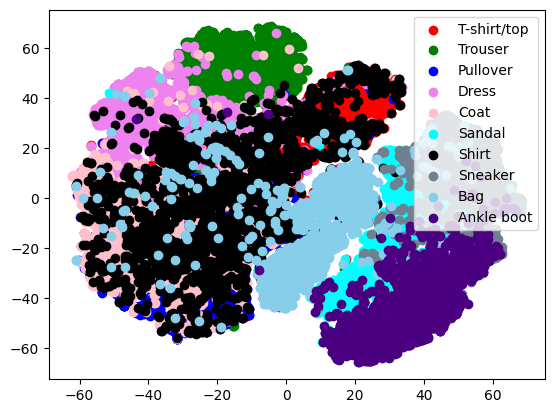

In [17]:
for i in range(10):
    d = df.where(df['label'] == i)
    plt.scatter(d['x'], d['y'],  color = color_list[i])
plt.legend(class_names)